In [108]:
import spacy

nlp = spacy.load("fr_core_news_lg")

In [ ]:
from pathlib import Path

import pandas as pd

DATA_FOLDER = Path(".") / "data"
PARTIES = list(DATA_FOLDER.glob("*.csv"))

dataset = pd.concat([pd.read_csv(party) for party in parties]).reset_index(drop=True)
dataset

In [110]:
import numpy as np

embeddings = np.array([t.vector for t in nlp.pipe(dataset["tweet"])])
embeddings

array([[-0.13547169, -1.6867433 , -1.1891791 , ..., -2.5764525 ,
         0.09715483, -2.5687616 ],
       [ 0.12396997, -0.39591748, -1.553725  , ..., -0.0432875 ,
        -1.1840802 , -0.77889305],
       [-0.6361    ,  0.15976374,  0.37649626, ..., -0.6740585 ,
         0.18155001,  0.5832375 ],
       ...,
       [ 0.33821198, -0.25420833, -2.8189275 , ...,  0.34838882,
        -0.09347892, -1.2838155 ],
       [-0.64363754, -0.52030253, -1.3720338 , ...,  0.43722498,
         0.99766374, -1.5139186 ],
       [-0.30315667, -0.010185  , -1.3418599 , ...,  1.0808233 ,
        -0.47571835, -0.859735  ]], dtype=float32)

In [111]:
from sklearn.manifold import TSNE

t_sne = TSNE(n_components=2, init='random').fit_transform(embeddings)

docs_2d = pd.DataFrame(t_sne, columns=["x", "y"])
docs_2d["category"] = dataset["account"].astype("category")
docs_2d

,x,y,category
0,-24.358616,-16.645479,partisocialiste
1,16.683046,2.663404,partisocialiste
2,-5.492063,-31.007269,partisocialiste
3,-27.293745,20.721369,partisocialiste
4,-31.969595,-11.495908,partisocialiste
...,...,...,...
1665,-15.955541,36.157417,EELV
1666,-1.003384,21.614553,EELV
1667,-21.764977,25.228870,EELV
1668,-5.814042,10.086063,EELV


<AxesSubplot: xlabel='x', ylabel='y'>

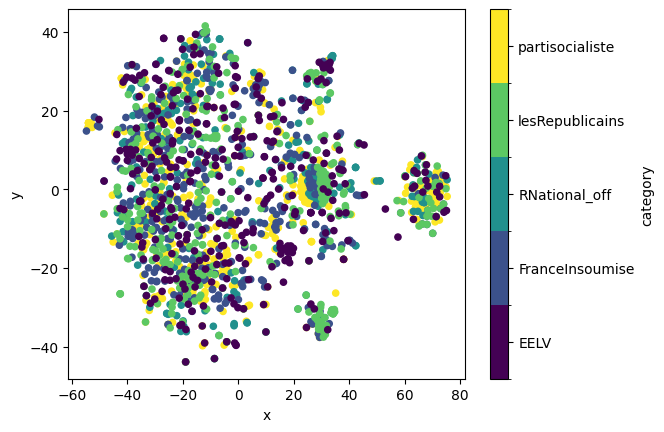

In [112]:
docs_2d.plot.scatter(x="x", y="y", c="category", colormap="viridis")

<AxesSubplot: xlabel='x', ylabel='y'>

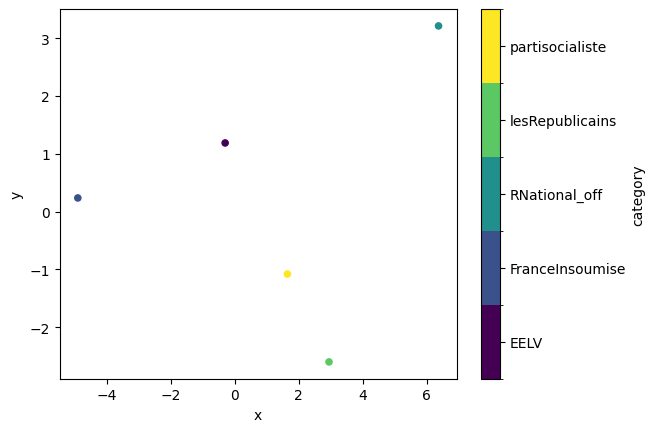

In [113]:
centroids = docs_2d.groupby('category').mean()
centroids["category"] = centroids.index
centroids.plot.scatter(x="x", y="y", c="category", colormap="viridis")

In [118]:
train_set = dataset.sample(frac=.8)
test_set = dataset.drop(train_set.index)

train_X, test_X = embeddings[train_set.index], embeddings[test_set.index]
train_y, test_y = train_set["account"], test_set["account"]

In [119]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, weights="distance").fit(train_X, train_y)

In [ ]:
def exp_predict(index_to_predict):
    row = dataset.iloc[index_to_predict]
    print(f"Predicting tweet '{row['tweet']}', expected account: {row['account']}")

    to_predict = test_X[index_to_predict].reshape(1, -1)
    predicted = knn.predict(to_predict)
    print(f"Predicted {predicted[0]}")

    nearest_neighbors = knn.kneighbors(to_predict)
    for distance, ind in zip(nearest_neighbors[0][0], nearest_neighbors[1][0]):
        nearest = dataset.iloc[ind]
        print(f"nearest includes: '{nearest['tweet']}' with a distance of {distance}, whose account was: '{nearest['account']}'\n")


exp_predict(test_y.index[0])